### This notebook gathers necessary data for TOPSIS analysis

In [1]:
import importlib.util
path_to_module = "/home/user1/Documents/school/math402/translink/optimizationResearch/optimization/location.py"
spec = importlib.util.spec_from_file_location("location", path_to_module)
lc = importlib.util.module_from_spec(spec)
spec.loader.exec_module(lc)

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

### Load landmarks

In [2]:
landmarks_df = pd.read_csv('landmarks-b20.csv')
landmarks_df.head()

,Landmarks,Latitude,Longitude
0,B100 West,49.209413,-123.066834
1,B100 East,49.210182,-123.065432
2,Fraserview Park,49.214787,-123.065217
3,Sir James Douglas Elem School,49.214997,-123.065217
4,Van Pub Lib-Fraserview,49.219903,-123.065391


### Initialize bus stops objects

In [3]:
stopsdf = pd.read_csv('../get_stops_data/b20-stops-data/b20-north-stops-data.csv')

# init stops
stops = []

# iterate through each stop and init BusStop objects
j = 0

for stop in stopsdf.iloc:
    connectedness = len(stop['Routes'].split(','))
    bstop = lc.BusStop(stop['Lat'], stop['Long'], stop['StopID'],[], j, connectedness)
    stops.append(bstop)
    j += 1

lmarks = []
# turn csv landmarks into location object
for entry in landmarks_df.iloc:
    lmarks.append(lc.Location(entry['Latitude'], entry['Longitude'], entry['Landmarks'] ,[]))


### Populate neighbourhoods of bus stops by landmarks

In [4]:
# find neighboring landmarks for each stop
for stop in stops:
    stop.findNeighbors(lmarks, 0.5)
#     print(stop, 'landmarks:',len(stop.neighborhood))


### Work with ridership data and do some filtering

In [5]:
rider_data_dir = '../../translink-data/project-data/20200124_sfu_stop_data_OCT.csv'
riderdf = pd.read_csv(rider_data_dir, converters={'from_no': str, 'to_no':str})
riderdf = riderdf[riderdf['direction'] == "NORTH"]
riderdf = riderdf[riderdf['line'] == 20]
riderdf = riderdf[riderdf['hour_24'] > 0]
riderdf = riderdf[riderdf['total_boardings'] < 60]
riderdf = riderdf[riderdf['total_alightings'] < 60]

### Count total boardings\alightings per stop during 1 month

In [6]:
boardings = {}
stopSampleCount = {}
stop_name = 'to_no'

for row in riderdf.iloc:

    if row[stop_name] in boardings:
        if row['day_type'] == 'MF':
            if stopSampleCount[row[stop_name]] < 200:
                boardings[row[stop_name]] += row['total_boardings']+row['total_alightings']
                stopSampleCount[row[stop_name]] += 1
    else:
        boardings[row[stop_name]] = row['total_boardings']+row['total_alightings']
        stopSampleCount[row[stop_name]] = 1
    

### Once total count is computed. Compute std of the total boardings/alightings and remove outliers

In [ ]:
from scipy import stats
all_boardings = list(boardings.values())

bmean = np.mean(all_boardings)
bstd = np.std(all_boardings)


boardings_cleaned = {}
stopSampleCount_cleaned = {}
skipped_keys =[]

for key,value in boardings.items():
    centered_value = np.abs(value - bmean)
    if centered_value < 2*bstd:
        boardings_cleaned[key] = value
        stopSampleCount_cleaned[key] = stopSampleCount[key]
    else:
        skipped_keys.append(key)
        
        
all_boardings_cleaned = list(boardings_cleaned.values()) 
stats.probplot(all_boardings_cleaned, dist="norm", plot=plt)

avg_boardings = np.mean(all_boardings_cleaned)

    
print('avg boardings:', avg_boardings)

print('num stops analyzed:', len(boardings_cleaned))

keys = [str(id) for id in boardings_cleaned.keys()]

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f'October counts, {len(boardings_cleaned)} stops NorthBound')

axs[0].bar(keys, boardings_cleaned.values(), color='g')

axs[0].tick_params(labelrotation=90)
axs[0].set_title('Boardings and Alightings')

axs[1].bar(keys, stopSampleCount_cleaned.values(), color='g')

axs[1].tick_params(labelrotation=90)

axs[1].set_title('Sample count')
plt.show()


### Compute population per bus stop withing the radius $dist$

In [ ]:
areadf = pd.read_csv("../stats-canada-data/DA.csv")
areadf.head()
areas = []

# iterate through each area and init Block objects
for area in areadf.iloc:
    area = lc.Block(area['DArplat'], area['DArplong'], area['DAuid'],int(area['DApop_2016']),int(area['DAurdwell_2016']), [])
    areas.append(area)

dist = 0.5
# find neighborhood for each stop
for stop in stops:
    stop.findNeighbors(areas, dist)

# for each stop aggregate pop in nbh areas
for stop in stops:
    pop = 0
    
    for area in stop.neighborhood:
        pop += area.pop
    
    stop.demand = {'nbh_pop':pop, 'demand':0}

    if str(stop.id) in boardings_cleaned.keys():
        stop.demand['demand'] = boardings_cleaned[str(stop.id)]
    else:
        stop.demand['demand'] = 0
    print(stop.id, stop.demand, 'connect:', stop.connectedness)



### Do linear regression to learn how to predict demand per bus stop

R^2: 0.3039371022604943


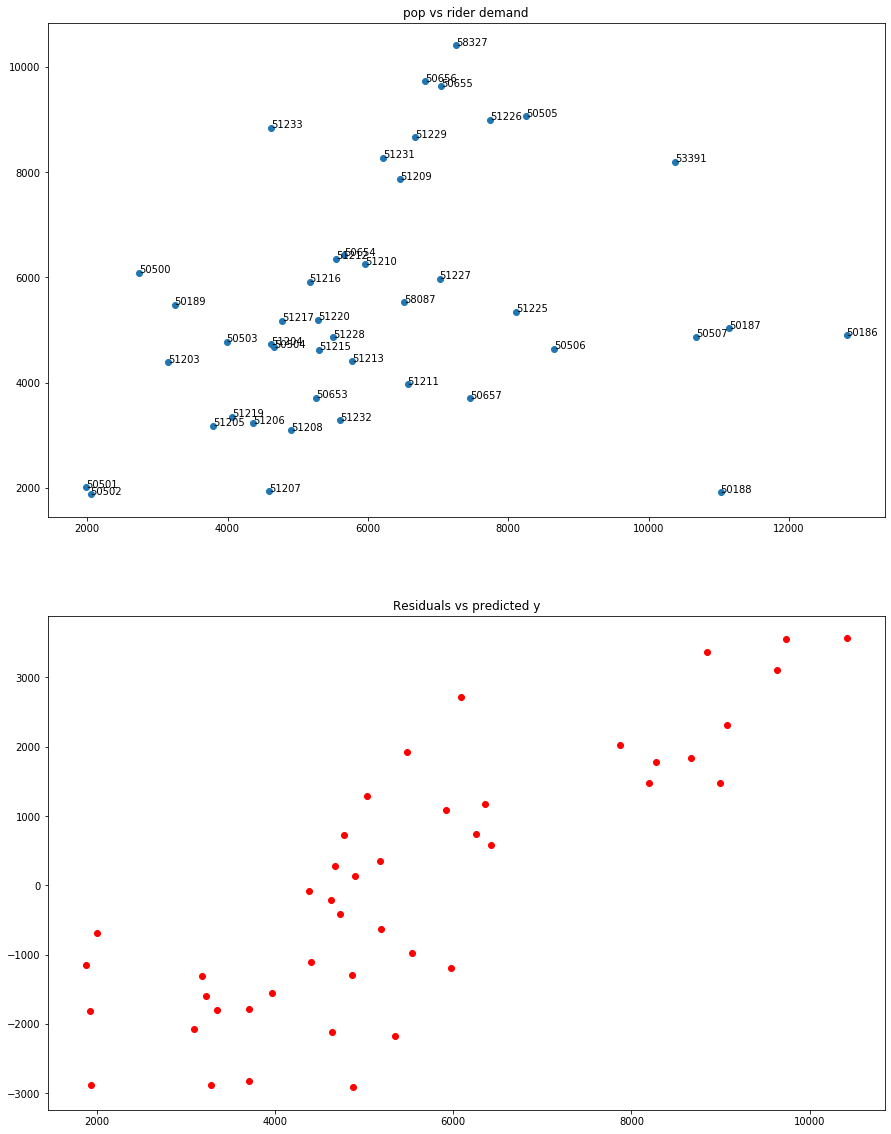

In [9]:
demand = []
pop = []
connect = []
stopid = []
num_landmarks = []

for stop in stops:
    if stop.demand['demand'] == 0: continue
    demand.append(stop.demand['demand'])
    pop.append(stop.demand['nbh_pop'])
    connect.append(int(stop.connectedness))
    stopid.append(stop.id)
    num_landmarks.append(len(stop.neighborhood))
    
    
from sklearn.linear_model import LinearRegression

X1 = np.array(pop).reshape(-1,1)
X2 = np.array(connect).reshape(-1,1)
X3 = np.array(num_landmarks).reshape(-1,1)
X = np.concatenate((X1,X2,X3),1)
y = np.array(demand)
reg = LinearRegression(fit_intercept=True)
reg.fit(X, y)

fig, ax = plt.subplots(2,1)
fig.set_size_inches(15, 20)
ax[0].scatter(pop, demand)
ax[0].set_title('pop vs rider demand')
for i, txt in enumerate(stopid):
    ax[0].annotate(txt, (pop[i], demand[i]))

resid = y - reg.predict(X)
ax[1].scatter(y, resid, color='r')
ax[1].set_title('Residuals vs predicted y')
print('R^2:', reg.score(X, y))

### Use linear regession model to predict demand for stops with incorrect demand


### Start TOPSIS analysis based on the demand, connectedness and proximity to landmarks

Text(0.5, 1.0, 'weight distribution')

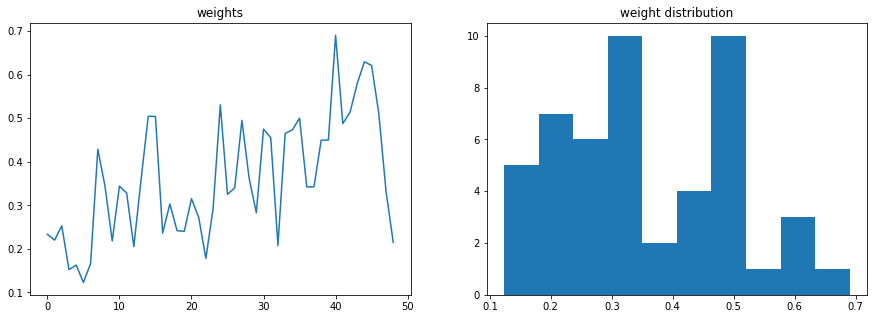

In [21]:
from skcriteria import Data, MIN, MAX

# create a matrix with all candidates
mtx = np.zeros((len(stops),3)).astype(int)
stopnames = []

for i in range(len(stops)):
    mtx[i,0] = stops[i].demand['demand']
    mtx[i,1] = stops[i].connectedness
    mtx[i,2] = len(stops[i].neighborhood)
    stopnames.append(stops[i].id)

    
# create criteria vector
criteria = [MAX, MAX, MAX]

# set weights for all criteria
weights = [0.45, 0.35, 0.2]

# create data object
data = Data(mtx, criteria, 
            anames=stopnames, 
            cnames=['demand', 'connectedness', 'landmarks'],
            weights=weights)

from skcriteria.madm import closeness, simple

dm = closeness.TOPSIS()
dec = dm.decide(data)
weights = dec.e_.closeness
    
fig, axs = plt.subplots(1,2)
fig.set_size_inches(15, 5)
axs[0].plot(weights)
axs[0].set_title('weights')
axs[1].hist(weights)
axs[1].set_title('weight distribution')


### Set weights for each bus stop and write out a CSV file

In [28]:
weights_series = pd.Series(weights, name='weights')
stopsdf_final = pd.concat([stopsdf, weights_series], axis=1)
for i in range(len(stops)):
    stop = stops[i]
    stop.weight = weights[i]

csv_file_path = '../get_stops_data/b20-stops-data/b20-north-stops-final.csv'
stopsdf_final.to_csv(csv_file_path, index=False)

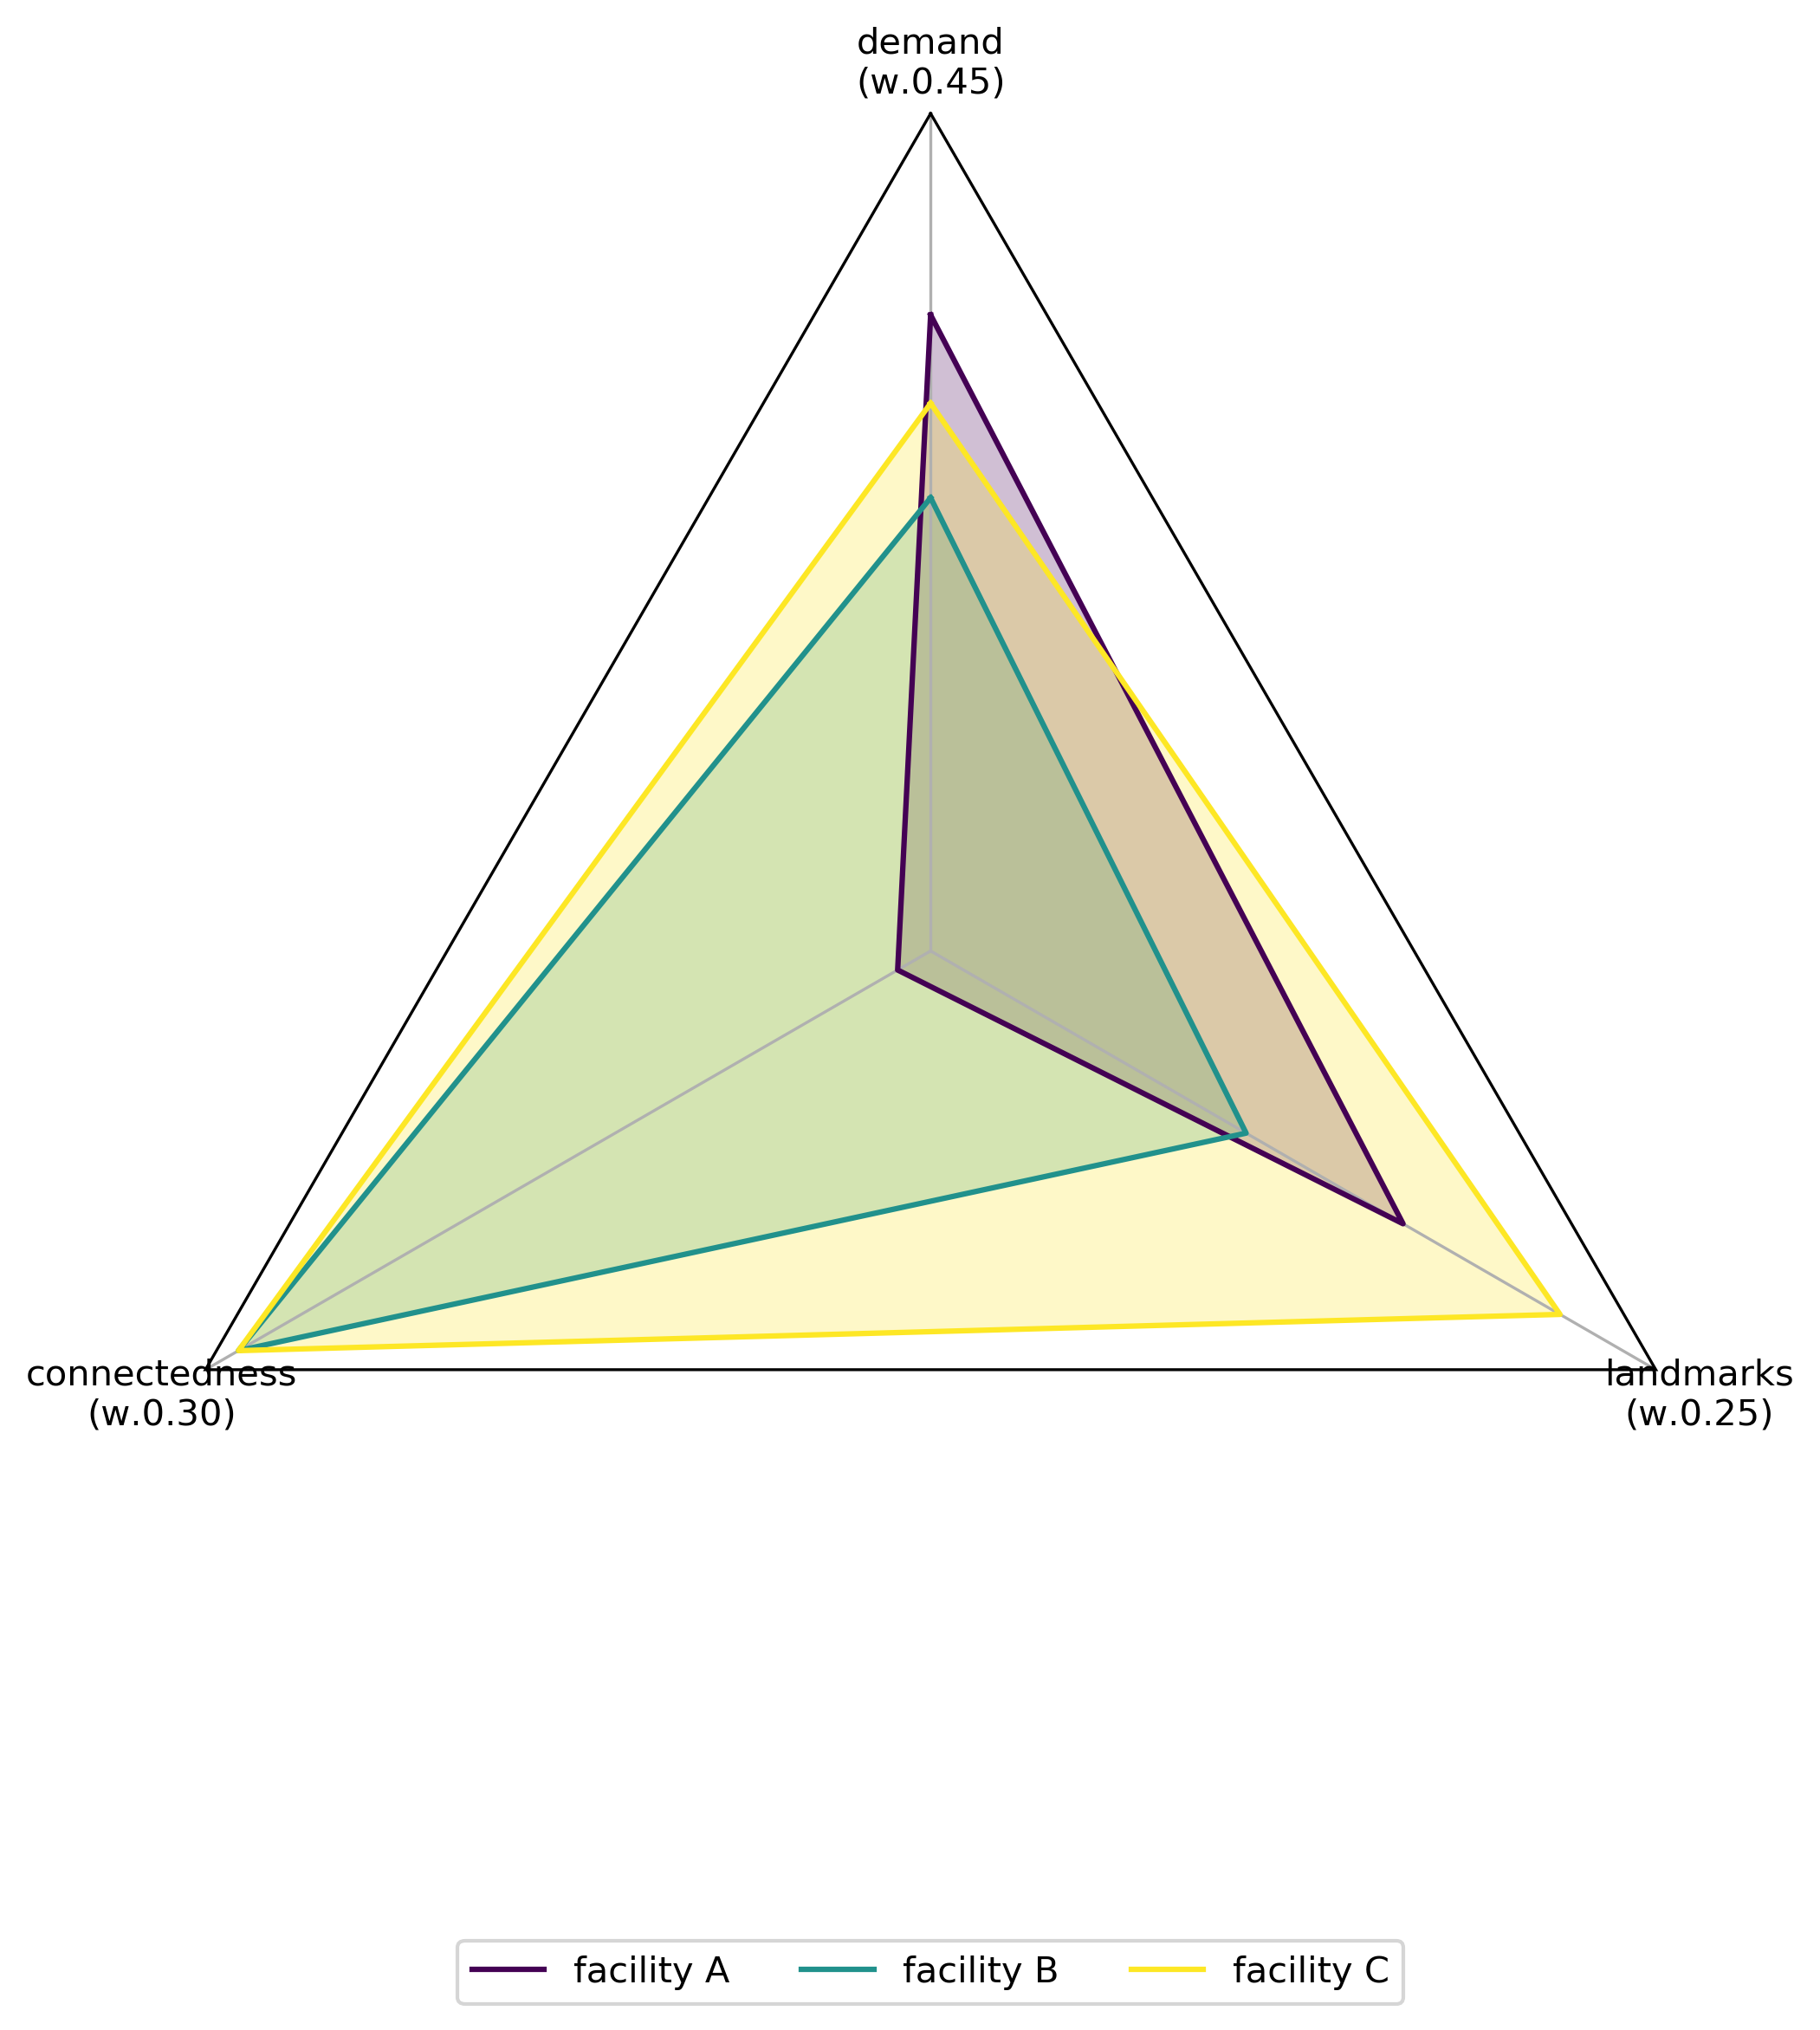

In [18]:
names = ['facility A', 'facility B', 'facility C']
viz_mtx = mtx[0:3,:]
viz_data = Data(viz_mtx, data.criteria, weights=data.weights, anames=names, cnames=data.cnames)


fig, axes = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='radar'))
fig.set_dpi(300)

viz_data.plot.radar(ax=axes,show_criteria=False)



[0.29448809 0.64332778 0.8587914 ]


<BarContainer object of 3 artists>

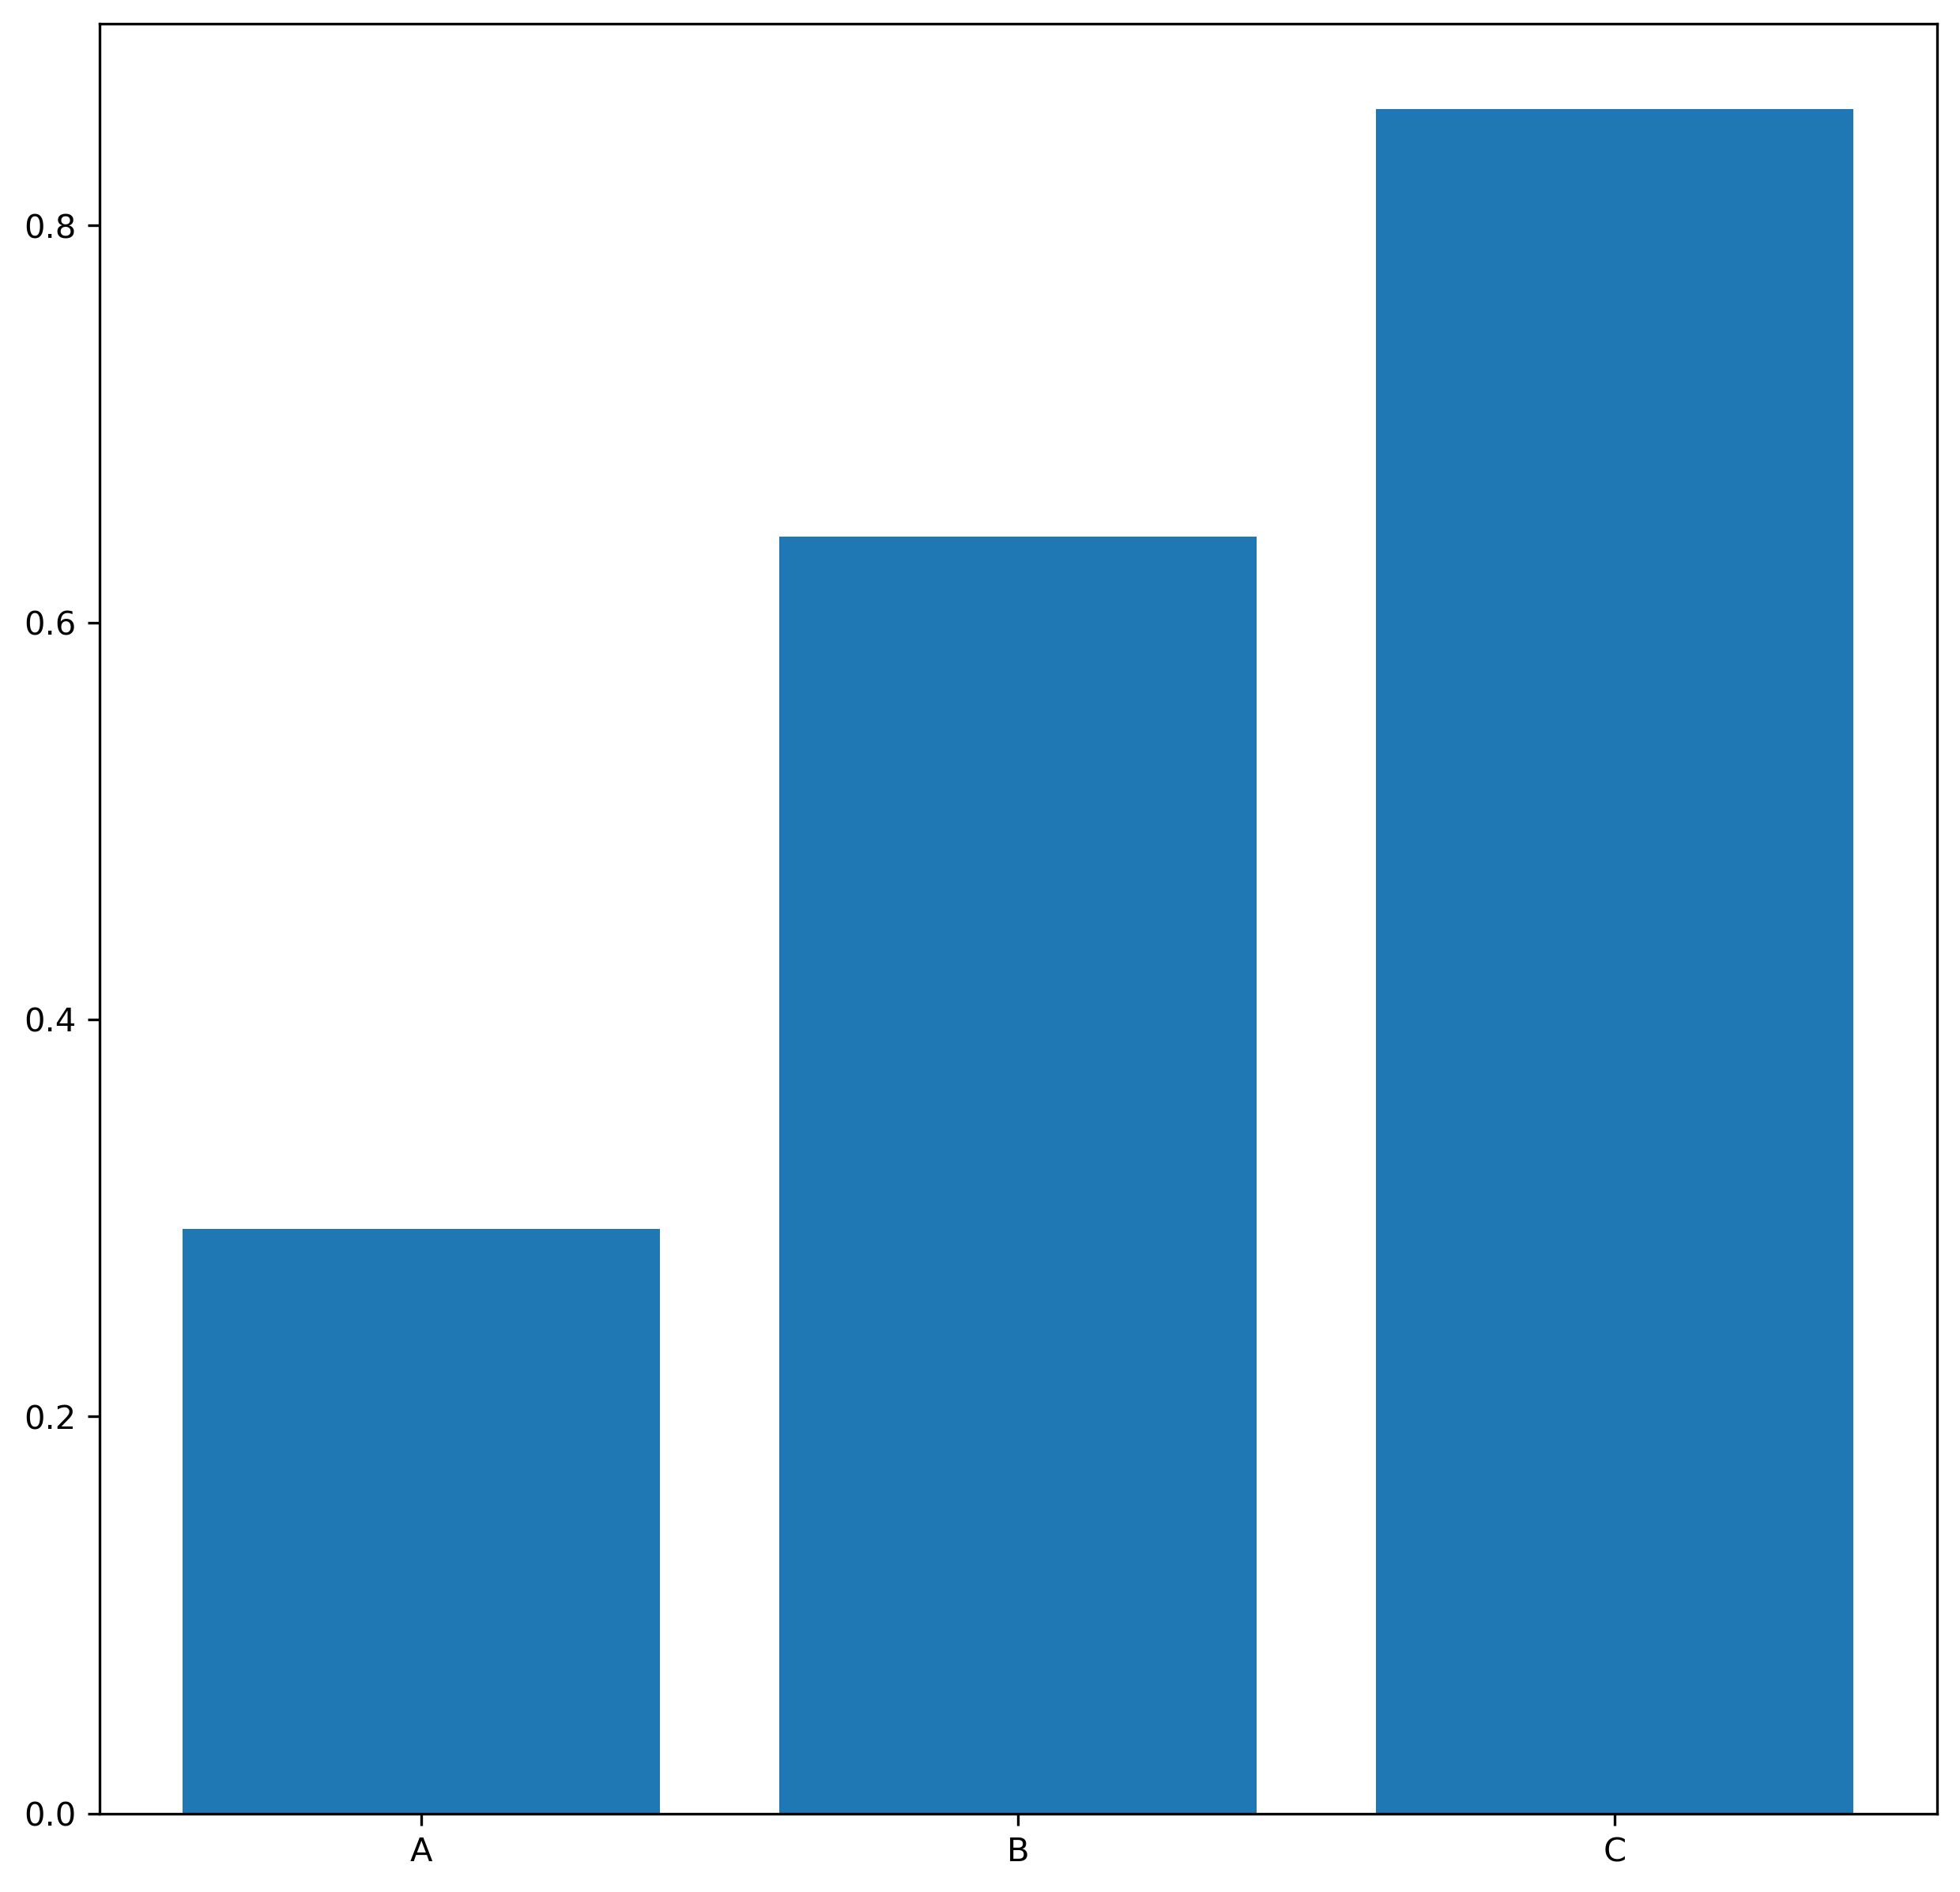

In [19]:
dm = closeness.TOPSIS()
dec = dm.decide(viz_data)
weights = dec.e_.closeness
print(weights)
fig, axs = plt.subplots(1,1)
fig.set_size_inches(10, 10)
fig.set_dpi(300)
plt.bar(['A','B','C'], weights)